In [1]:
import numpy as np
from shapely.geometry.polygon import LinearRing, Polygon
import json
import math
from datetime import datetime
from shapely import box, LineString, normalize, Polygon, Point

In [2]:
def make_circle(radius = 1, shape=1, x0=0, y0=0, nPoints=500):
    theta = np.linspace(0,2*np.pi, nPoints)
    xx = radius * np.sin(theta) + x0
    yy = radius * np.cos(theta) + y0
    segs = []
    for idx, (x, y) in enumerate(zip(xx, yy)):
        if idx<1:
            px, py = x, y
            continue
        seg = (px, py, x, y, shape)
        segs.append(seg)
        px, py = x, y
    return segs
make_rectangle = lambda l, w, x0=0, y0=0: Polygon([ Point([l*ver[0], w*ver[1]]) for ver in [(-1, -1), (1, -1), (1, 1), (-1, 1)]])
    

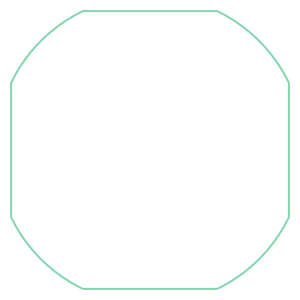

In [3]:
def make_mosfire_fov(l=6.12, r=3.4, shape=1):
    circ = Polygon([Point(seg[0:2]) for seg in make_circle(r * 60 * 2 , 1, 0, 0, 100)])
    square = make_rectangle(l * 60, l * 60)
    mf = square.intersection(circ)
    segs = []

    for idx, (x, y) in enumerate(zip(mf.exterior.xy[0], mf.exterior.xy[1])):
        if idx<1:
            px, py = x, y
            continue
        seg = (px, py, x, y, shape)
        segs.append(seg)
        px, py = x, y
    return segs, mf
segs, mf = make_mosfire_fov()
    
strSegs = [" ".join(x)+'\n' for x in [[str(el) for el in seg] for seg in segs]]
mosfireshape = [[seg[0], seg[1]] for seg in segs]
mf.exterior

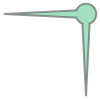

In [4]:
# Generate the compass rose
import shapely.geometry as sg
import matplotlib.pyplot as plt
from shapely.affinity import rotate, scale

def create_compass_rose(center, radius, baseWidthRat=0.1):
    """Creates a Shapely compass rose polygon."""
    x, y = center

    # Create the main circle
    circle = sg.Point(center).buffer(radius/8)
    baseWidth = radius * baseWidthRat

    # Create the N, S, E, W arms
    north = sg.Polygon([(x - baseWidth/2 , y), (x, y + radius), (x + baseWidth/2, y), (x - baseWidth/2, y)])
    west = rotate(north, 90, center)
    south = rotate(north, 180, center)
    east = rotate(north, 270, center)

    # Create the NE, NW, SE, SW arms
    mag = .707
    ne = rotate( scale(north, mag, mag), -45, center)
    nw = rotate( scale(north, mag, mag), 45, center)
    se = rotate( scale(north, mag, mag), 45+180, center)
    sw = rotate( scale(north, mag, mag), -45+180, center)

    # Combine all the elements
    # compass_rose = circle.union(north).union(south).union(east).union(west).union(ne).union(nw).union(se).union(sw)
    compass_rose = circle.union(north).union(east)
    compass_rose = rotate(compass_rose, 180) # Rotate so that coordinates will match the canvas 

    return compass_rose

# Create the compass rose
needleLen = 50 # Length of the needle in pixels
compass = create_compass_rose((0, 0), needleLen)
compasscoords = list(zip(compass.exterior.xy[0], compass.exterior.xy[1]))

# Plot the compass rose
compass

In [5]:
def create_compass_rose_colored(center, radius, baseWidthRat=0.1, radFactor = 1/8):
    """Creates a Shapely compass rose polygon."""
    x, y = center

    # Create the main circle
    circle = sg.Point(center).buffer(radius * radFactor)
    baseWidth = radius * baseWidthRat

    # Create the N, S, E, W arms
    north = sg.Polygon([(x - baseWidth/2, y), (x, y + radius),
                       (x + baseWidth/2, y), (x - baseWidth/2, y)])
    east = rotate(north, 270, center)

    north = rotate(north, 180)
    east = rotate(east, 180)
    return [circle, north.difference(circle), east.difference(circle)]


# Create the compass rose
needleLen = 50 # Length of the needle in pixels
compass_colored = create_compass_rose_colored((0, 0), needleLen)
cc_colored = [list(zip(x.exterior.xy[0], x.exterior.xy[1]))
              for x in compass_colored]

offset = -1 * needleLen * (1 + 1/8)

compassRoseFC = {"type": "", "properties":
                 {
                     "name": "compassRose",
                     "type": "static shape"
                 },
                 "features": [
                     {"type": "Feature", 
                      "properties": {"type": "circle", 
                                    "color": "white",
                                    "offsetx": 0, "offsety": 0,
                                    "fill": "white"},
                      "geometry": {"type": "Polygon", "coordinates": cc_colored[0]}},
                     {"type": "Feature", 
                      "properties": {"type": "northPin", 
                                     "color": "red",
                                     "offsetx": 0, "offsety": offset,
                                     "fill": "red"},
                      "geometry": {"type": "Polygon", "coordinates": cc_colored[1]}},
                     {"type": "Feature", 
                      "properties": {"type": "eastPin",
                                     "color": "green",
                                     "offsetx": offset, "offsety": 0,
                                     "fill": "green"},
                      "geometry": {"type": "Polygon", "coordinates": cc_colored[2]}}
                 ]}

In [ ]:
zoom = .15/2
fovs = {
            'OSIRISImager' : {'fov': 
                    [[1024,1024,512,512,0.02*6,0],
                     [48,64,24,32,0.1,-47.5] ], 
                    'zoom': zoom, 'dome': 'Keck 1'},
            'OSIRISSpec' : {'fov': [[1024,1024,512,512,0.02*6,0],
                            [48,64,24,32,0.1,- 47.5] ],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'OSIRISImagerTrick' : {'fov': 
                    [[1024,1024,512,512,0.02*6,0],
                            [48,64,24,32,0.1,- 47.5] ],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'OSIRISSpecTrick' : {'fov': [[1024,1024,512,512,0.02*6,0],
                            [48,64,24,32,0.1,- 47.5]],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'NIRC2Narrow' : {'fov': [ [1024,1024,512,512,0.009942*2,0.7]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'NIRC2Medium' : {'fov': [ [1024,1024,512,512,0.019829*2,0.7]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'NIRC2Wide' : {'fov': [ [1024,1024,512,512,0.039686*2,0.7]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'HIRES' : {'fov': [[1024,1024,548,481,0.086,180]],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'LRISADC' : {'fov': [[1024,1024,495,520,0.136,-116]],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'MOSFIRE' : {'fov': [[1024,1024,512,512,0.164,90]],
                    'zoom': zoom, 'dome': 'Keck 1'},
            'ESI' : {'fov': [[1024,1024,512,256,0.2342,0]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'KCWI' : {'fov': [[1024,621,512,311,0.03223,0.0],
                    [496,621,248,311,0.03223,0.0],
                    [248,621,124,311,0.03223,0.0] ],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'DEIMOS': {'fov': [[1024,1024,512,800,0.207,1.2]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'NIRSPEC' : {'fov': [[1024,1024,512,156,0.211,0.6]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'NIRSPAO' : {'fov': [[1024,1024,512,512,0.134,0]],
                    'zoom': zoom, 'dome': 'Keck 2'},
            'NIRES' : {'fov': [[512,512,255,255,0.22/2,180]],
                    'zoom': zoom, 'dome': 'Keck 2'}
}

In [22]:
def make_fov(fov, rects, zoom, dome):
    instshapes = []
    for rect in rects:
        l, w, x0, y0, scale, rot = rect
        l, w, x0, y0 = [x*scale for x in [l, w, x0, y0]] 
        rect = make_rectangle(l, w, l - 2*x0, w - 2*y0)
        rect = rotate(rect, rot)
        shape = list(zip(rect.exterior.xy[0], rect.exterior.xy[1]))
        instshapes.append(shape)

    if fov == 'KCWI':
        c1, c2 = make_circle(136, 2, 0, 0, 200), make_circle(65, 3, 0, 0, 200)
        ag1, ag2 = [ [x[0], x[1]] for x in c1 ], [ [ x[0], x[1] ] for x in c2 ]
        instshapes.append(ag1)
        instshapes.append(ag2)

    return { 
    "type": "Feature",
    "properties": {"instrument": fov, "dome": dome, "type": "FOV", "zoom": zoom, "units": "arcsec"},
    "geometry": {
        "type": "MultiPolygon",
        "coordinates": 
            instshapes 
        }
    }

features = []
for fov, sz in fovs.items():
    rects, zoom, dome = sz['fov'], sz['zoom'], sz['dome']
    feature = make_fov(fov, rects, zoom, dome)
    if 'MOSFIRE' in fov: #overwrite the mosfire fov with the one we generated
        feature['geometry']['coordinates'] = [mosfireshape]
    features.append(feature)

In [23]:

instGeoJSON = { "type": "FeatureCollection", "features": features}
shapes = {'compass_rose': compassRoseFC, 'fov': instGeoJSON}
with open('./public/FEATURES.json', 'w') as f:
    json.dump(shapes, f, indent = 2)

In [ ]:
#SCRATCH

In [ ]:
# c1, c2 = make_circle(136, 2, 0, 0, 200), make_circle(65, 3, 0, 0, 200)

# segs = [ *c1, *c2]
# kcwishape = [ [ [x[0], x[1]] for x in c1 ], [ [ x[0], x[1] ] for x in c2 ] ]

instGeoJSON = { "type": "FeatureCollection",
    "features": [
{ 
  "type": "Feature",
  "properties": {"instrument": "KCWI", "type": "FOV", "zoom": .15, "units": "arcsec"},
  "geometry": {
    "type": "MultiPolygon",
    "coordinates": 
      kcwishape
    }
},
        { 
  "type": "Feature",
  "properties": {"instrument": "MOSFIRE", "type": "FOV", "zoom": .5, "units": "pixels"},
  "geometry": {
    "type": "MultiPolygon",
    "coordinates": 
      [mosfireshape]
    }
}
    ]}

shapes = {'compass_rose': compassRoseFC, 'fov': instGeoJSON}
with open('./public/FEATURES.json', 'w') as f:
    json.dump(shapes, f, indent = 2)